# HSAF Training Course
## Lab 1 – Drought monitoring through H SAF SM products

In this exercise we will

* Get ASCAT Data Record, ERA5 time-series and RZSM time-series
* Move the data into the correct location
* Read time-series data
* Visualize time-series and map data
* Extract data for a given point and/or time step
* Performing some analysis using soil moisture, SWI index and droughts indexes

### Libraries

In [30]:
%matplotlib inline

# Libraries
import os
import calendar
import datetime
import numpy as np
import pandas as pd
from os.path import join

from library.cima.domain_utils import get_grid, get_file_shp, get_file_json, create_points_shp
from library.cima.ts_utils import df_time_matching, df_temporal_matching, df_period_selection
from library.cima.ts_dset_reader import dset_init, dset_config, dset_period
from library.cima.map_utils import interpolate_point2map, create_map, create_image

from library.irpi.indices.drought import ssi, spi

from pytesmo.scaling import get_scaling_function, get_scaling_method_lut
from pytesmo.time_series.filters import exp_filter
from pytesmo.time_series import anomaly

from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib.colors as mc
# Info
print('Libraries loaded!')

Libraries loaded!


### Exercise Configuration
#### In the configuration part:
* select your basin
* set correct paths of the data
* select time period of datasets
* set thresholds of snow and frozen conditions to filter ASCAT dataset

In [2]:
# Domain
domain = 'italy'
file_shp_domain = 'tiber_basin.shp'
file_tiff_domain = 'tiber_basin.tiff'

# Path(s)
data_path_dyn = os.path.join('/home', 'fabio', 'hsaf_data', 'dynamic')
data_path_static = os.path.join('/home', 'fabio', 'hsaf_data', 'static')

tmp_path = os.path.join('tmp')
img_path = os.path.join('img')

ascat_path_ts = os.path.join(data_path_dyn, 'ascat_dr', domain)
ascat_path_grid = os.path.join(data_path_static, 'warp5_grid')
ascat_path_layers = os.path.join(data_path_static, 'warp5_layers')
ascat_path_tmp = os.path.join(tmp_path, 'ascat')

era5_path_ts = os.path.join(data_path_dyn, 'era5_ts', domain)
era5_path_grid = os.path.join(data_path_dyn, 'era5_ts', domain)
era5_path_tmp = os.path.join(tmp_path, 'era5')

rzsm_path_ts = os.path.join(data_path_dyn, 'rzsm_ts', domain)
rzsm_path_grid = os.path.join(data_path_dyn, 'rzsm_ts', domain)
rzsm_path_tmp = os.path.join(tmp_path, 'rzsm')

domain_path_layer = os.path.join(data_path_static, 'shp', domain)
exercize_path_img = os.path.join(img_path, 'lab1')

# Parametershp
ascat_mask_frozen_prob_threshold = 100   # if mask value is greater than threshold the value is discarded
ascat_mask_snow_prob_threshold = 100     # if mask value is greater than threshold the value is discarded

time_start = "2007-01-01" # format "%Y-%m-%d"
time_end = "2014-12-31"   # "format %Y-%m-%d"  

temporal_matching = 24
temporal_drop_duplicates = False

max_dist = 35000

# Create img path
if not os.path.exists(exercize_path_img):
    os.makedirs(exercize_path_img)

### Basin Configuration
The script loads the shapefile of the basin and creates a mask using the defined cell_size (degree) and boudary box buffer (bbox_ext in degree). 
After running the cell, results can be check using QGIS

In [3]:
# Get basin information using a shapefile
basin_rows, basin_cols, basin_epsg, basin_transform, basin_meta_reference = get_file_shp(
    os.path.join(domain_path_layer, file_shp_domain),
    os.path.join(domain_path_layer, file_tiff_domain),
    cell_size=0.005, bbox_ext=0)
# Print information about basin 
print(basin_rows, basin_cols, basin_epsg, basin_transform)

(232, 201, 'EPSG:4326', Affine(0.005, 0.0, 11.911873170287814,
       0.0, -0.005, 43.79852126600523))


/home/fabio/hsaf_conda/envs/work_env/lib/python2.7/site-packages/rasterio/features.py:303: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)
/home/fabio/hsaf_conda/envs/work_env/lib/python2.7/site-packages/rasterio/__init__.py:160: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


In [4]:
# Create basin grid using WARP5 reference system
basin_grid, basin_lons_2d, basin_lats_2d, basin_bbox = get_grid(
    os.path.join(domain_path_layer, file_tiff_domain))
# Print information about basin 
print(basin_bbox)
# Using QGIS to:
# 1) load basin shapefile
# 2) load basin tiff
# 3) check results

BoundingBox(left=11.911873170287814, bottom=42.638521266005235, right=12.916873170287815, top=43.79852126600523)


### Datasets configuration
In this part ASCAT, ERA5 and RZSM datasets are configured using parameters and paths set previously.
- Step 1 -- Create settings dictionary to summarize information about datasets

In [5]:
# Create ASCAT, ERA5 and RZSM settings
settings = {  
    "ascat_path_ts": ascat_path_ts,
    "ascat_path_grid": ascat_path_grid,
    "ascat_path_layer": ascat_path_layers,
    "ascat_path_tmp": ascat_path_tmp,
    "ascat_mask_frozen_prob_threshold": ascat_mask_frozen_prob_threshold,
    "ascat_mask_snow_prob_threshold": ascat_mask_snow_prob_threshold,
    "era5_path_ts": era5_path_ts,
    "era5_path_grid": era5_path_grid,
    "era5_path_tmp": era5_path_tmp,
    "rzsm_path_ts": rzsm_path_ts,
    "rzsm_path_grid": rzsm_path_grid,
    "rzsm_path_tmp": rzsm_path_tmp,
    "domain_path_layer": domain_path_layer,
    "time_start": time_start,
    "time_end": time_end,
    "temporal_matching": temporal_matching,
    "temporal_drop_duplicates": temporal_drop_duplicates,
    "max_dist": max_dist
}

* Step 2 -- Initialize and configure reader objects for ASCAT, ERA5 and RZSM datasets

In [6]:
# Initialize ASCAT, ERA5 and RZSM datasets
reader_ascat, reader_era5, reader_rzsm = dset_init(settings)
datasets = dset_config(reader_ascat, reader_era5, reader_rzsm, settings)

* Step 3 -- Find GPIS of ASCAT, ERA5 and RZSM datasets using basin reference

In [7]:
# Create ASCAT, ERA5 and RZSM grid(s) using basin information
# Get ascat gpi(s)
gpis_ascat, lats_ascat, lons_ascat = reader_ascat.grid.get_bbox_grid_points(
    latmin=basin_bbox.bottom, latmax=basin_bbox.top, lonmin=basin_bbox.left,
    lonmax=basin_bbox.right, both=True)
gpis_ascat_n = gpis_ascat.__len__()
# Get era5 gpi(s)
gpis_era5, lats_era5, lons_era5 = reader_era5.grid.get_bbox_grid_points(
    latmin=basin_bbox.bottom, latmax=basin_bbox.top, lonmin=basin_bbox.left,
    lonmax=basin_bbox.right, both=True)
gpis_era5_n = gpis_era5.__len__()
# Get rzsm gpi(s)
gpis_rzsm, lats_rzsm, lons_rzsm = reader_rzsm.grid.get_bbox_grid_points(
    latmin=basin_bbox.bottom, latmax=basin_bbox.top, lonmin=basin_bbox.left,
    lonmax=basin_bbox.right, both=True)
gpis_rzsm_n = gpis_rzsm.__len__()

# Print information about ASCAT, ERA5 and RZSM gpi(s) numerosity
print("ASCAT GPIS N: " + str(gpis_ascat_n))
print("ERA5 GPIS N: " + str(gpis_era5_n))
print("RZSM GPIS N: " + str(gpis_rzsm_n))

ASCAT GPIS N: 73
ERA5 GPIS N: 20
RZSM GPIS N: 56


- Step 4 -- Verify, for each dataset, if there are enough gpis inside the basin.
Using QGIS, load the created shapefiles and check the gpis availability.

In [8]:
# Find ASCAT gpi(s) over basin (using a maximum distance parameter)
gpis_basin_ascat = basin_grid.calc_lut(reader_ascat.grid, max_dist=settings['max_dist'])
gpis_basin_ascat = np.unique(gpis_basin_ascat)
lons_basin_ascat, lats_basin_ascat = reader_ascat.grid.gpi2lonlat(gpis_basin_ascat)
# Create shapefile of ASCAT gpi(s) over basin
create_points_shp(gpis_basin_ascat, lons_basin_ascat, lats_basin_ascat, 
                  file_name_shp=os.path.join(domain_path_layer, 'lab1_basin_ascat.shp'))

In [9]:
# Find ERA5 gpi(s) over basin (using a maximum distance parameter)
gpis_basin_era5 = basin_grid.calc_lut(reader_era5.grid, max_dist=settings['max_dist'])
gpis_basin_era5 = np.unique(gpis_basin_era5)
lons_basin_era5, lats_basin_era5 = reader_era5.grid.gpi2lonlat(gpis_basin_era5)
# Create shapefile of ERA5 gpi(s) over basin
create_points_shp(gpis_basin_era5, lons_basin_era5, lats_basin_era5, 
                  file_name_shp=os.path.join(domain_path_layer, 'lab1_basin_era5.shp'))

In [10]:
# Find RZSM gpi(s) over basin (using a maximum distance parameter)
gpis_basin_rzsm = basin_grid.calc_lut(reader_rzsm.grid, max_dist=settings['max_dist'])
gpis_basin_rzsm = np.unique(gpis_basin_rzsm)
lons_basin_rzsm, lats_basin_rzsm = reader_rzsm.grid.gpi2lonlat(gpis_basin_rzsm)
# Create shapefile of RZSM gpi(s) over basin
create_points_shp(gpis_basin_rzsm, lons_basin_rzsm, lats_basin_rzsm, 
                  file_name_shp=os.path.join(domain_path_layer, 'lab1_basin_rzsm.shp'))

* Step 5 -- Find gpis of ERA5 and RZSM using ASCAT as reference dataset

In [11]:
# Define ASCAT, ERA5 and RZSM common gpis
gpis_ascat_ws = reader_ascat.grid.find_nearest_gpi(lons_ascat, lats_ascat, max_dist=settings['max_dist'])
gpis_ascat = gpis_ascat_ws[0]; dist_ascat = gpis_ascat_ws[1];
lons_ascat, lats_ascat = reader_ascat.grid.gpi2lonlat(gpis_ascat)

gpis_era5_ws = reader_era5.grid.find_nearest_gpi(lons_ascat, lats_ascat, max_dist=settings['max_dist'])
gpis_era5 = gpis_era5_ws[0]; dist_era5 = gpis_era5_ws[1];
lons_era5, lats_era5 = reader_era5.grid.gpi2lonlat(gpis_era5)

gpis_rzsm_ws = reader_rzsm.grid.find_nearest_gpi(lons_ascat, lats_ascat, max_dist=settings['max_dist'])
gpis_rzsm = gpis_rzsm_ws[0]; dist_rzsm = gpis_rzsm_ws[1];
lons_rzsm, lats_rzsm = reader_rzsm.grid.gpi2lonlat(gpis_rzsm)

### A. Extract ASCAT,  ERA5 and RZSM datasets
#### 1. Extract the time-series of ASCAT and RZSM
* get all GPIS over domain
* resample to weekly values

In [12]:
# Compute ASCAT monthly time-series
ts_resample = pd.DataFrame()
ts_res= pd.DataFrame()
for id, (gpi_ascat, lon_ascat, lat_ascat) in enumerate(zip(gpis_basin_ascat, lons_basin_ascat, lats_basin_ascat)):
    
    # Get ASCAT data
    print(' ==> Step: ' + str(id+1) + '/' + str(gpis_basin_ascat.shape[0]))
    
    ts_SM = 'sm_' + str(gpi_ascat)
    ts_ascat = reader_ascat.read_ts(gpi_ascat)
    ts_ascat = ts_ascat.loc[settings['time_start']:settings['time_end']]
    ts_res['sm']= ts_ascat.sm.resample('W').mean().dropna()
    ts_res['day'] = ts_res.sm.index.day
    ts_res['month'] = ts_res.sm.index.month
    ts_res['year'] = ts_res.sm.index.year
    ts_res['doy'] = ts_res.sm.index.dayofyear
    ts_resample[ts_SM] = ts_ascat.sm.resample('W').mean().dropna()
    
ts_resample['mean']=ts_resample.mean(axis=1)
ts_resample['day']=ts_res['day']
ts_resample['month']=ts_res['month']
ts_resample['year']=ts_res['year'] 
ts_resample['doy']=ts_res['doy']

 ==> Step: 1/82
 ==> Step: 2/82
 ==> Step: 3/82
 ==> Step: 4/82
 ==> Step: 5/82
 ==> Step: 6/82
 ==> Step: 7/82
 ==> Step: 8/82
 ==> Step: 9/82
 ==> Step: 10/82
 ==> Step: 11/82
 ==> Step: 12/82
 ==> Step: 13/82
 ==> Step: 14/82
 ==> Step: 15/82
 ==> Step: 16/82
 ==> Step: 17/82
 ==> Step: 18/82
 ==> Step: 19/82
 ==> Step: 20/82
 ==> Step: 21/82
 ==> Step: 22/82
 ==> Step: 23/82
 ==> Step: 24/82
 ==> Step: 25/82
 ==> Step: 26/82
 ==> Step: 27/82
 ==> Step: 28/82
 ==> Step: 29/82
 ==> Step: 30/82
 ==> Step: 31/82
 ==> Step: 32/82
 ==> Step: 33/82
 ==> Step: 34/82
 ==> Step: 35/82
 ==> Step: 36/82
 ==> Step: 37/82
 ==> Step: 38/82
 ==> Step: 39/82
 ==> Step: 40/82
 ==> Step: 41/82
 ==> Step: 42/82
 ==> Step: 43/82
 ==> Step: 44/82
 ==> Step: 45/82
 ==> Step: 46/82
 ==> Step: 47/82
 ==> Step: 48/82
 ==> Step: 49/82
 ==> Step: 50/82
 ==> Step: 51/82
 ==> Step: 52/82
 ==> Step: 53/82
 ==> Step: 54/82
 ==> Step: 55/82
 ==> Step: 56/82
 ==> Step: 57/82
 ==> Step: 58/82
 ==> Step: 59/82
 ==> S

In [13]:
# Compute H27 monthly time-series
ts_resample_rzsm = pd.DataFrame()
ts_res_rzsm= pd.DataFrame()
for id, (gpi_ascat, lon_ascat, lat_ascat) in enumerate(zip(gpis_basin_ascat, lons_basin_ascat, lats_basin_ascat)):
    
    # Select gpi for RZSM and ERA5
    gpi_rzsm = reader_rzsm.grid.find_nearest_gpi(lon_ascat, lat_ascat, max_dist=settings['max_dist'])[0]
    lon_rzsm, lat_rzsm = reader_rzsm.grid.gpi2lonlat(gpi_rzsm)
    
    gpi_era5 = reader_era5.grid.find_nearest_gpi(lon_ascat, lat_ascat, max_dist=settings['max_dist'])[0]
    lon_era5, lat_era5 = reader_era5.grid.gpi2lonlat(gpi_era5)
    
    # Get RZSM data
    print(' ==> Step: ' + str(id+1) + '/' + str(gpis_basin_ascat.shape[0]))
    
    ts_SM_rzsm = 'sm_' + str(gpi_ascat)
    
    ts_rzsm = reader_rzsm.read_ts(gpi_rzsm)
    ts_rzsm = ts_rzsm.loc[settings['time_start']:settings['time_end']]
    ts_res_rzsm['sm']= ts_rzsm.var40.resample('W').mean().dropna()
    ts_res_rzsm['day'] = ts_res_rzsm.sm.index.day
    ts_res_rzsm['month'] = ts_res_rzsm.sm.index.month
    ts_res_rzsm['year'] = ts_res_rzsm.sm.index.year
    ts_res_rzsm['doy'] = ts_res_rzsm.sm.index.dayofyear
    ts_resample_rzsm[ts_SM_rzsm] = ts_rzsm.var40.resample('W').mean().dropna()
    
ts_resample_rzsm['mean']=ts_resample_rzsm.mean(axis=1)
ts_resample_rzsm['day']=ts_res_rzsm['day']
ts_resample_rzsm['month']=ts_res_rzsm['month']
ts_resample_rzsm['year']=ts_res_rzsm['year'] 
ts_resample_rzsm['doy']=ts_res_rzsm['doy']

 ==> Step: 1/82
 ==> Step: 2/82
 ==> Step: 3/82
 ==> Step: 4/82
 ==> Step: 5/82
 ==> Step: 6/82
 ==> Step: 7/82
 ==> Step: 8/82
 ==> Step: 9/82
 ==> Step: 10/82
 ==> Step: 11/82
 ==> Step: 12/82
 ==> Step: 13/82
 ==> Step: 14/82
 ==> Step: 15/82
 ==> Step: 16/82
 ==> Step: 17/82
 ==> Step: 18/82
 ==> Step: 19/82
 ==> Step: 20/82
 ==> Step: 21/82
 ==> Step: 22/82
 ==> Step: 23/82
 ==> Step: 24/82
 ==> Step: 25/82
 ==> Step: 26/82
 ==> Step: 27/82
 ==> Step: 28/82
 ==> Step: 29/82
 ==> Step: 30/82
 ==> Step: 31/82
 ==> Step: 32/82
 ==> Step: 33/82
 ==> Step: 34/82
 ==> Step: 35/82
 ==> Step: 36/82
 ==> Step: 37/82
 ==> Step: 38/82
 ==> Step: 39/82
 ==> Step: 40/82
 ==> Step: 41/82
 ==> Step: 42/82
 ==> Step: 43/82
 ==> Step: 44/82
 ==> Step: 45/82
 ==> Step: 46/82
 ==> Step: 47/82
 ==> Step: 48/82
 ==> Step: 49/82
 ==> Step: 50/82
 ==> Step: 51/82
 ==> Step: 52/82
 ==> Step: 53/82
 ==> Step: 54/82
 ==> Step: 55/82
 ==> Step: 56/82
 ==> Step: 57/82
 ==> Step: 58/82
 ==> Step: 59/82
 ==> S

#### 2. Create a pivot table to organize data using month as a reference

In [14]:
# Create pivot tables using months as indices for ASCAT soil moisture (H113)
ts_pivot = pd.pivot_table(ts_resample, index=['month'], columns=['year'], values=['mean'])
ts_group = pd.DataFrame()
ts_group['sm'] = ts_resample.groupby(['month'])['mean'].mean()
ts_group['index'] = ts_group.sm.index

In [15]:
# Create pivot tables using months as indices for ECMEF Root zone soil moisture (H27)
ts_pivot_rzsm = pd.pivot_table(ts_resample_rzsm, index=['month'], columns=['year'], values=['mean'])
ts_group_rzsm = pd.DataFrame()
ts_group_rzsm['sm'] = ts_resample_rzsm.groupby(['month'])['mean'].mean()
ts_group_rzsm['index'] = ts_group_rzsm.sm.index

#### 3. Compute soil moisture anomalies using average values 

In [23]:
# Calculate anomaly based on moving +- anomaly_window_size/2 day window [anomaly_window_size = 35, 50 ...]
anomaly_window_size = 200
ts_anomaly = pd.DataFrame()
ts_anomaly['sm'] = anomaly.calc_anomaly(ts_resample['mean'], window_size=anomaly_window_size)
ts_anomaly['time'] = ts_anomaly.sm.index
# Subset anomaly
ts_anomaly_period = ts_anomaly.loc[
    (ts_anomaly['time'] > '2006') & (ts_anomaly['time'] <= '2008')]

In [24]:
# Calculate anomaly based on moving +- anomaly_window_size/2 day window [anomaly_window_size = 35, 50 ...]
anomaly_window_size = 200
ts_anomaly_rzsm = pd.DataFrame()
ts_anomaly_rzsm['sm'] = anomaly.calc_anomaly(ts_resample_rzsm['mean'], window_size=anomaly_window_size)
ts_anomaly_rzsm['time'] = ts_anomaly_rzsm.sm.index
# Subset anomaly
ts_anomaly_rzsm_period = ts_anomaly_rzsm.loc[
    (ts_anomaly_rzsm['time'] > '2006') & (ts_anomaly_rzsm['time'] <= '2008')]

### Plot Time-Series

#### 1. Plot time-series of ASCAT interannual monthly soil moisture values 

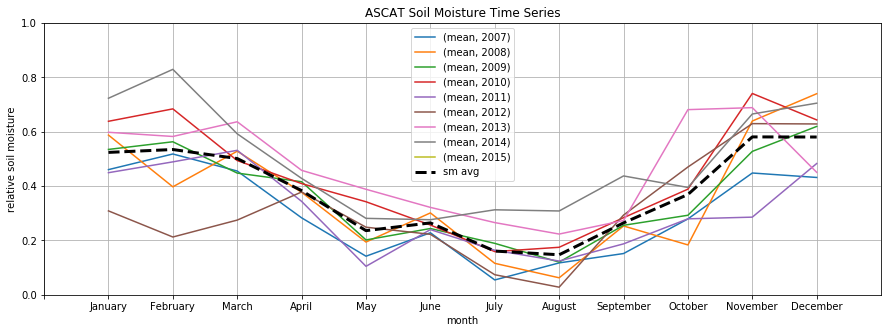

In [25]:
# Plot ASCAT sm time-series interannual means
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ts_pivot.plot(ax=ax, label='sm')
ts_group['sm'].plot(ax=ax, label= 'sm avg', color='#000000', lw=3, style='--')

ax.set_xlim(0, 13)
ax.set_ylim(0, 1)
ax.grid(b=True) 
ax.set_title('ASCAT Soil Moisture Time Series')
ax.set_ylabel('relative soil moisture')

plt.xticks(np.arange(13), calendar.month_name[0:13])
plt.legend()

filename = os.path.join(exercize_path_img, "lab1_ts_sm_avg.tiff")
fig.savefig(filename, dpi=120)

#### 2. Plot time-series of ECMWF interannual monthly root zone soil moisture values

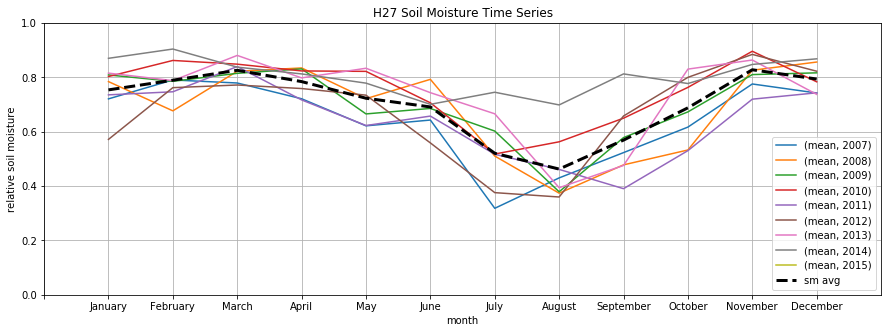

In [26]:
# Plot H27 sm time-series interannual means
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ts_pivot_rzsm.plot(ax=ax, label='sm')
ts_group_rzsm['sm'].plot(ax=ax, label= 'sm avg', color='#000000', lw=3, style='--')

ax.set_xlim(0, 13)
ax.set_ylim(0, 1)
ax.grid(b=True) 
ax.set_title('H27 Soil Moisture Time Series')
ax.set_ylabel('relative soil moisture')

plt.xticks(np.arange(13), calendar.month_name[0:13])
plt.legend()

filename = os.path.join(exercize_path_img, "lab1_ts_rzsm_avg.tiff")
fig.savefig(filename, dpi=120)

#### 3. Plot time-series of ASCAT soil moisture anomalies

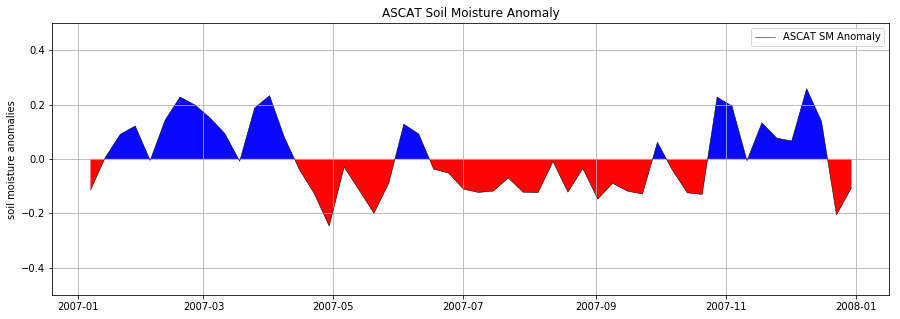

In [27]:
# Plot ASCAT soil moisture variable for a gpi over domain
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(ts_anomaly_period['sm'], lw=0.5, label='ASCAT SM Anomaly', color='#000000')

ax.fill_between(ts_anomaly_period.index, ts_anomaly_period['sm'].values,
                where=ts_anomaly_period['sm'] >= 0,
                facecolor='#0000FF', alpha=10, interpolate=True)

ax.fill_between(ts_anomaly_period.index, ts_anomaly_period['sm'].values,
                where=ts_anomaly_period['sm'] < 0,
                facecolor='#FF0000', alpha=5, interpolate=True)

ax.set_ylim(-0.5, 0.5)
ax.grid(b=True) 
ax.set_title('ASCAT Soil Moisture Anomaly')
ax.set_ylabel('soil moisture anomalies')

plt.legend()

filename = os.path.join(exercize_path_img, "lab1_ts_sm_anomaly.tiff")
fig.savefig(filename, dpi=120)

#### 4. Plot time-series of ECMWF root zone soil moisture anomalies

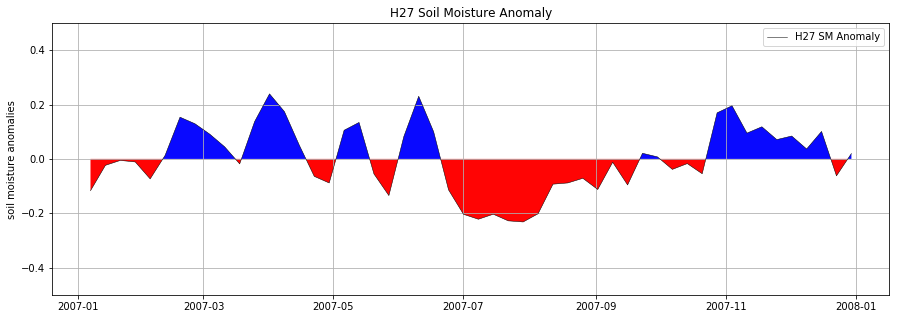

In [28]:
# Plot H27 soil moisture variable for a gpi over domain
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(ts_anomaly_rzsm_period['sm'], lw=0.5, label='H27 SM Anomaly', color='#000000')

ax.fill_between(ts_anomaly_rzsm_period.index, ts_anomaly_rzsm_period['sm'].values,
                where=ts_anomaly_rzsm_period['sm'] >= 0,
                facecolor='#0000FF', alpha=10, interpolate=True)

ax.fill_between(ts_anomaly_rzsm_period.index, ts_anomaly_rzsm_period['sm'].values,
                where=ts_anomaly_rzsm_period['sm'] < 0,
                facecolor='#FF0000', alpha=5, interpolate=True)

ax.set_ylim(-0.5, 0.5)
ax.grid(b=True) 
ax.set_title('H27 Soil Moisture Anomaly')
ax.set_ylabel('soil moisture anomalies')

plt.legend()

filename = os.path.join(exercize_path_img, "lab1_ts_rzsm_anomaly.tiff")
fig.savefig(filename, dpi=120)

### B. Extract ASCAT,  ERA5 and RZSM datasets
#### 1. Extract the time-series of ASCAT and RZSM
* get all GPIS over domain
* define accumulation period for droughts (drough_accum_period in months)
* resample to daily values
* compute droughts indexes (SSI and SPI)

In [90]:
from scipy.stats import norm

idx=2
acc_per = 2
gpi_ascat = gpis_basin_ascat[idx]
ts_ascat_raw = reader_ascat.read_ts(gpi_ascat)
ts_ascat_avg['avg'] = ts_ascat_raw['sm'].resample('D').mean().dropna()

month_values = ts_ascat_avg['avg'].resample('MS').mean()
month_values = month_values.interpolate()
accum_period = month_values.rolling(acc_per).mean()

accum_period = accum_period.dropna()

SSI = accum_period.copy()
print(SSI.head(n=12))

mesi = np.arange(1, 13)

for jj in mesi:

    dfM = accum_period[accum_period.index.month == jj]

    series = dfM.values
    series = series[~np.isnan(series)]
    n = len(series)
    bp = np.zeros(len(series))

    for ii in range(len(series)):
        bp[ii] = np.sum(series <= series[ii])

    # Plotting position formula Gringorten
    y = (bp - 0.44) / (n + 0.12);
    z = norm.ppf(y)

    SSI.iloc[accum_period.index.month == jj] = z

print(SSI.head(n=12))

2007-02-01    0.505384
2007-03-01    0.447484
2007-04-01    0.267300
2007-05-01    0.173596
2007-06-01    0.218792
2007-07-01    0.137196
2007-08-01    0.046278
2007-09-01    0.108119
2007-10-01    0.215341
2007-11-01    0.337045
2007-12-01    0.388636
2008-01-01    0.471591
Freq: MS, Name: sm, dtype: float64
2007-02-01    0.000000
2007-03-01   -0.738136
2007-04-01   -1.079027
2007-05-01   -0.738136
2007-06-01   -0.227360
2007-07-01   -0.738136
2007-08-01   -0.738136
2007-09-01   -1.641376
2007-10-01   -1.641376
2007-11-01   -1.641376
2007-12-01   -1.641376
2008-01-01   -0.380523
Freq: MS, Name: sm, dtype: float64


In [110]:
from scipy.stats import norm

idx=2
acc_per = 2
gpi_ascat = gpis_basin_ascat[idx]
lon_ascat = lons_basin_ascat[idx]
lat_ascat = lats_basin_ascat[idx]
gpi_era5 = reader_era5.grid.find_nearest_gpi(lon_ascat, lat_ascat, max_dist=settings['max_dist'])[0]

ts_era5_raw = reader_era5.read_ts(gpi_era5)

ts_era5_avg = pd.DataFrame()
ts_era5_avg['avg'] = ts_era5_raw['tp'].resample('D').mean().dropna()
ts_era5_avg['month'] = ts_era5_avg['avg'].index.month

ts_era5_avg.loc[ts_era5_avg['month'] == 1, 'avg'] = 0

month_values = ts_era5_avg['avg'].resample('MS').mean()
month_values = month_values.interpolate()
accum_period = month_values.rolling(acc_per).mean()




accum_period = accum_period.dropna()

#print(accum_period.head(n=12))


            avg  month
2007-01-01  0.0      1
2007-01-02  0.0      1
2007-01-03  0.0      1
2007-01-04  0.0      1
2007-01-05  0.0      1
2007-01-06  0.0      1
2007-01-07  0.0      1
2007-01-08  0.0      1
2007-01-09  0.0      1
2007-01-10  0.0      1
2007-01-11  0.0      1
2007-01-12  0.0      1


In [103]:
# Compute drought SSI index based on ASCAT time-series
drough_accum_period = 2
ts_drought_ssi = pd.DataFrame()
ts_ascat_ws = pd.DataFrame()
for id, (gpi_ascat, lon_ascat, lat_ascat) in enumerate(zip(gpis_basin_ascat, lons_basin_ascat, lats_basin_ascat)):
    
    # Get ASCAT data
    print(' ==> Step: ' + str(id+1) + '/' + str(gpis_basin_ascat.shape[0]))
    
    ts_sm = 'sm_' + str(gpi_ascat)
    ts_anml = 'anml_' + str(gpi_ascat)
    dr_ssi = 'ssi_' + str(gpi_ascat)
    
    ts_ascat = reader_ascat.read_ts(gpi_ascat)
    ts_ascat = ts_ascat.loc[settings['time_start']:settings['time_end']]
    
    ts_ascat_ws[ts_sm] = ts_ascat.sm.resample('D').mean().dropna()
    ts_ascat_ws[ts_anml] = anomaly.calc_anomaly(ts_ascat_ws[ts_sm], window_size=anomaly_window_size)
    
    print(ts_ascat_ws.head())
    
    ts_drought_ssi[dr_ssi] = ssi(ts_ascat_ws, drough_accum_period, ts_sm)
    
# Compute ssi average values
ts_drought_ssi['mean']=ts_drought_ssi.mean(axis=1)

 ==> Step: 1/82
            sm_2204747  anml_2204747
2007-01-02       0.420     -0.085444
2007-01-04       0.280     -0.218804
2007-01-05       0.445     -0.050484
2007-01-06       0.370     -0.121383
2007-01-07       0.470     -0.018474


ValueError: cannot set using a list-like indexer with a different length than the value

In [32]:
# Compute drought SSI index based on ECMWF time-series
drough_accum_period = 1
ts_drought_ssi_rzsm = pd.DataFrame()
ts_rzsm_ws = pd.DataFrame()
for id, (gpi_ascat, lon_ascat, lat_ascat) in enumerate(zip(gpis_basin_ascat, lons_basin_ascat, lats_basin_ascat)):
       
    # Select gpi for RZSM and ERA5
    gpi_rzsm = reader_rzsm.grid.find_nearest_gpi(lon_ascat, lat_ascat, max_dist=settings['max_dist'])[0]
    lon_rzsm, lat_rzsm = reader_rzsm.grid.gpi2lonlat(gpi_rzsm)
    
    gpi_era5 = reader_era5.grid.find_nearest_gpi(lon_ascat, lat_ascat, max_dist=settings['max_dist'])[0]
    lon_era5, lat_era5 = reader_era5.grid.gpi2lonlat(gpi_era5)
    
    # Get ECMWF data
    print(' ==> Step: ' + str(id+1) + '/' + str(gpis_basin_ascat.shape[0]))
    
    ts_sm2 = 'sm_' + str(gpi_ascat)
    ts_rzsm_anml = 'anml_' + str(gpi_ascat)
    dr_rzsm_ssi = 'ssi_' + str(gpi_ascat)
    
    ts_rzsm = reader_rzsm.read_ts(gpi_rzsm)
    ts_rzsm = ts_rzsm.loc[settings['time_start']:settings['time_end']]
    
    ts_rzsm_ws[ts_sm2] = ts_rzsm.var40.resample('D').mean().dropna()
    ts_rzsm_ws[ts_rzsm_anml] = anomaly.calc_anomaly(ts_rzsm_ws[ts_sm2], window_size=anomaly_window_size)
    
    ts_drought_ssi_rzsm[dr_rzsm_ssi] = ssi(ts_rzsm_ws, drough_accum_period, ts_sm2)
    
# Compute ssi average values
ts_drought_ssi_rzsm['mean']=ts_drought_ssi_rzsm.mean(axis=1)

 ==> Step: 1/82
 ==> Step: 2/82
 ==> Step: 3/82
 ==> Step: 4/82
 ==> Step: 5/82
 ==> Step: 6/82
 ==> Step: 7/82
 ==> Step: 8/82
 ==> Step: 9/82
 ==> Step: 10/82
 ==> Step: 11/82
 ==> Step: 12/82
 ==> Step: 13/82
 ==> Step: 14/82
 ==> Step: 15/82
 ==> Step: 16/82
 ==> Step: 17/82
 ==> Step: 18/82
 ==> Step: 19/82
 ==> Step: 20/82
 ==> Step: 21/82
 ==> Step: 22/82
 ==> Step: 23/82
 ==> Step: 24/82
 ==> Step: 25/82
 ==> Step: 26/82
 ==> Step: 27/82
 ==> Step: 28/82
 ==> Step: 29/82
 ==> Step: 30/82
 ==> Step: 31/82
 ==> Step: 32/82
 ==> Step: 33/82
 ==> Step: 34/82
 ==> Step: 35/82
 ==> Step: 36/82
 ==> Step: 37/82
 ==> Step: 38/82
 ==> Step: 39/82
 ==> Step: 40/82
 ==> Step: 41/82
 ==> Step: 42/82
 ==> Step: 43/82
 ==> Step: 44/82
 ==> Step: 45/82
 ==> Step: 46/82
 ==> Step: 47/82
 ==> Step: 48/82
 ==> Step: 49/82
 ==> Step: 50/82
 ==> Step: 51/82
 ==> Step: 52/82
 ==> Step: 53/82
 ==> Step: 54/82
 ==> Step: 55/82
 ==> Step: 56/82
 ==> Step: 57/82
 ==> Step: 58/82
 ==> Step: 59/82
 ==> S

In [41]:
# Compute drought SPI index based on ERA5 time-series
drough_accum_period = 1
ts_drought_spi = pd.DataFrame()
ts_era5_ws = pd.DataFrame()
for id, (gpi_ascat, lon_ascat, lat_ascat) in enumerate(zip(gpis_basin_ascat, lons_basin_ascat, lats_basin_ascat)):
       
    # Select gpi for RZSM and ERA5
    gpi_rzsm = reader_rzsm.grid.find_nearest_gpi(lon_ascat, lat_ascat, max_dist=settings['max_dist'])[0]
    lon_rzsm, lat_rzsm = reader_rzsm.grid.gpi2lonlat(gpi_rzsm)
    
    gpi_era5 = reader_era5.grid.find_nearest_gpi(lon_ascat, lat_ascat, max_dist=settings['max_dist'])[0]
    lon_era5, lat_era5 = reader_era5.grid.gpi2lonlat(gpi_era5)
    
    # Get ERA5 data
    print(' ==> Step: ' + str(id+1) + '/' + str(gpis_basin_ascat.shape[0]))
    
    ts_tp = 'tp_' + str(gpi_ascat)
    ts_skt = 'skt_' + str(gpi_ascat)
    dr_spi = 'spi_' + str(gpi_ascat)
    
    ts_era5 = reader_era5.read_ts(gpi_era5)
    ts_era5 = ts_era5.loc[settings['time_start']:settings['time_end']]
    
    ts_era5_ws[ts_tp] = ts_era5.tp.resample('D').mean().dropna()
    ts_era5_ws[ts_tp] = ts_era5.tp.resample('D').mean().dropna()
    
    ts_drought_spi[dr_spi] = spi(ts_era5_ws, drough_accum_period, ts_tp)

# Compute ssi average values
ts_drought_spi['mean']=ts_drought_spi.mean(axis=1)

 ==> Step: 1/82
 ==> Step: 2/82
 ==> Step: 3/82
 ==> Step: 4/82
 ==> Step: 5/82
 ==> Step: 6/82
 ==> Step: 7/82
 ==> Step: 8/82
 ==> Step: 9/82
 ==> Step: 10/82
 ==> Step: 11/82
 ==> Step: 12/82
 ==> Step: 13/82
 ==> Step: 14/82
 ==> Step: 15/82
 ==> Step: 16/82
 ==> Step: 17/82
 ==> Step: 18/82
 ==> Step: 19/82
 ==> Step: 20/82
 ==> Step: 21/82
 ==> Step: 22/82
 ==> Step: 23/82
 ==> Step: 24/82
 ==> Step: 25/82
 ==> Step: 26/82
 ==> Step: 27/82
 ==> Step: 28/82
 ==> Step: 29/82
 ==> Step: 30/82
 ==> Step: 31/82
 ==> Step: 32/82
 ==> Step: 33/82
 ==> Step: 34/82
 ==> Step: 35/82
 ==> Step: 36/82
 ==> Step: 37/82
 ==> Step: 38/82
 ==> Step: 39/82
 ==> Step: 40/82
 ==> Step: 41/82
 ==> Step: 42/82
 ==> Step: 43/82
 ==> Step: 44/82
 ==> Step: 45/82
 ==> Step: 46/82
 ==> Step: 47/82
 ==> Step: 48/82
 ==> Step: 49/82
 ==> Step: 50/82
 ==> Step: 51/82
 ==> Step: 52/82
 ==> Step: 53/82
 ==> Step: 54/82
 ==> Step: 55/82
 ==> Step: 56/82
 ==> Step: 57/82
 ==> Step: 58/82
 ==> Step: 59/82
 ==> S

### Plot time-series

#### 1. Plot timeseries of SSI index based on ASCAT soil moisture values

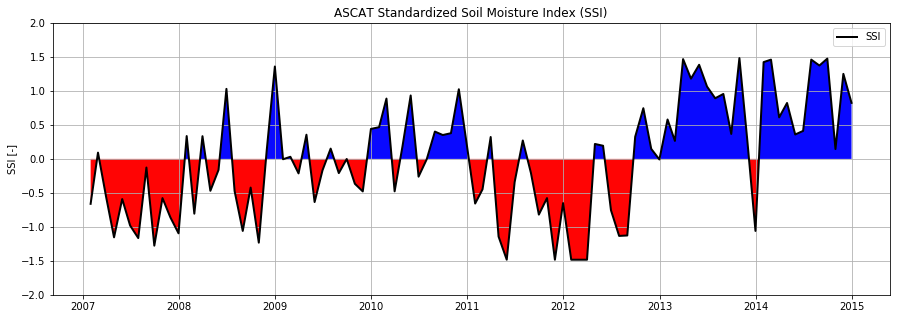

In [42]:
# Plot average ASCAT SSI index
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(ts_drought_ssi['mean'], lw=2, label='SSI', color='#000000')

ax.fill_between(ts_drought_ssi.index, ts_drought_ssi['mean'].values,
                where=ts_drought_ssi['mean'] >= 0,
                facecolor='#0000FF', alpha=10, interpolate=True)

ax.fill_between(ts_drought_ssi.index, ts_drought_ssi['mean'].values,
                where=ts_drought_ssi['mean'] < 0,
               facecolor='#FF0000', alpha=5, interpolate=True)

ax.set_ylim(-2, 2)
ax.grid(b=True) 
ax.set_title('ASCAT Standardized Soil Moisture Index (SSI)')
ax.set_ylabel('SSI [-]')

plt.legend()

filename = os.path.join(exercize_path_img, "lab1_ts_ssi_avg.tiff")
fig.savefig(filename, dpi=120)

#### 2. Plot timeseries of SSI index based on ECMWF root zone soil moisture values

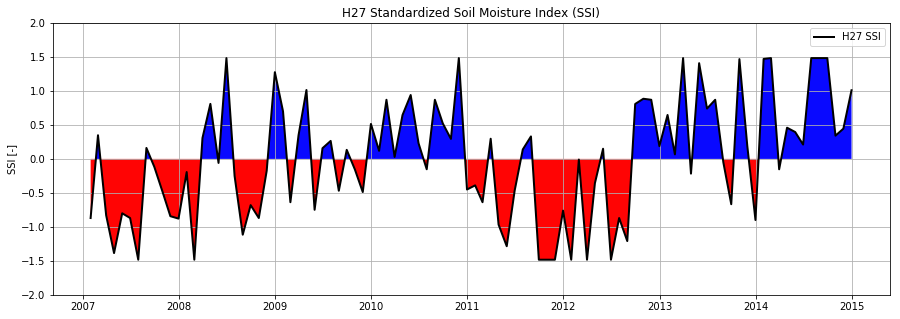

In [44]:
# Plot average H27 SSI index
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(ts_drought_ssi_rzsm['mean'], lw=2, label='H27 SSI', color='#000000')

ax.fill_between(ts_drought_ssi_rzsm.index, ts_drought_ssi_rzsm['mean'].values,
                where=ts_drought_ssi_rzsm['mean'] >= 0,
                facecolor='#0000FF', alpha=10, interpolate=True)

ax.fill_between(ts_drought_ssi_rzsm.index, ts_drought_ssi_rzsm['mean'].values,
                where=ts_drought_ssi_rzsm['mean'] < 0,
               facecolor='#FF0000', alpha=5, interpolate=True)

ax.set_ylim(-2, 2)
ax.grid(b=True) 
ax.set_title('H27 Standardized Soil Moisture Index (SSI)')
ax.set_ylabel('SSI [-]')

plt.legend()

filename = os.path.join(exercize_path_img, "lab1_ts_H27_ssi_avg.tiff")
fig.savefig(filename, dpi=120)

#### 3. Plot timeseries of SPI index based on ERA5 root zone soil moisture values

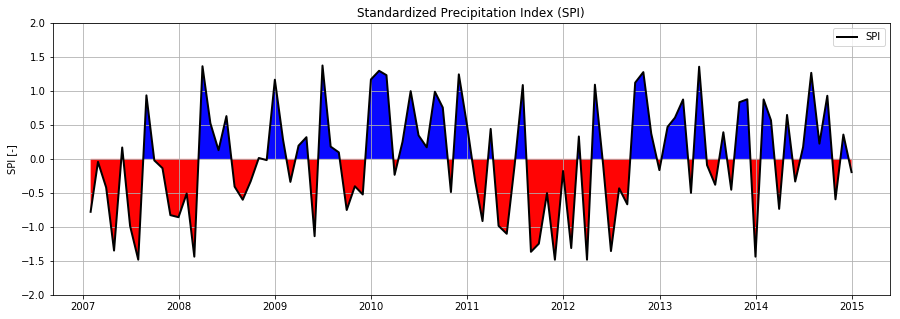

In [45]:
# Plot average SPI index
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(ts_drought_spi['mean'], lw=2, label='SPI', color='#000000')

ax.fill_between(ts_drought_spi.index, ts_drought_spi['mean'].values,
                where=ts_drought_spi['mean'] >= 0,
                facecolor='#0000FF', alpha=10, interpolate=True)

ax.fill_between(ts_drought_spi.index, ts_drought_spi['mean'].values,
                where=ts_drought_spi['mean'] < 0,
               facecolor='#FF0000', alpha=5, interpolate=True)

ax.set_ylim(-2, 2)
ax.grid(b=True) 
ax.set_title('Standardized Precipitation Index (SPI)')
ax.set_ylabel('SPI [-]')

plt.legend()

filename = os.path.join(exercize_path_img, "lab1_ts_spi_avg.tiff")
fig.savefig(filename, dpi=120)

### C. Extract ASCAT,  ERA5 and RZSM datasets
#### 1. Extract data of ASCAT and RZSM for a selected date
* define a time analysis (time_analysis)
* compute soil moisture and soil moisture anomalies

In [46]:
# Define a tine analysis for mapping results [%Y-%m-%d %H:%M"]
time_analysis = "2010-11-15 00:00"

# Convert time to first and last day of month
date_analysis = datetime.datetime.strptime(time_analysis, "%Y-%m-%d %H:%M")
year_analysis = date_analysis.strftime('%Y')
month_analysis = date_analysis.strftime('%m')
day_analysis = calendar.monthrange(int(year_analysis), int(month_analysis))[1]

data_analysis_first_day = date_analysis.replace(day = 1)
data_analysis_last_day = date_analysis.replace(day = calendar.monthrange(date_analysis.year, date_analysis.month)[1])
time_analysis_first_day = data_analysis_first_day.strftime("%Y-%m-%d")
time_analysis_last_day = data_analysis_last_day.strftime("%Y-%m-%d")

In [47]:
# Get ASCAT data for a selected date
pnt_ascat_ws = pd.DataFrame(columns=['lon', 'lat', 'gpi', 'sm', 'anomaly', 'time'])
for id, (gpi_ascat, lon_ascat, lat_ascat) in enumerate(zip(gpis_basin_ascat, lons_basin_ascat, lats_basin_ascat)):
    
    ts_sm = 'sm_' + str(gpi_ascat)
    ts_anml = 'anml_' + str(gpi_ascat)

    pnt_ascat_sm = df_time_matching(ts_ascat_ws[ts_sm], time_analysis, 
                                    window=200)[0]
    pnt_ascat_anml = df_time_matching(ts_ascat_ws[ts_anml], time_analysis, 
                                    window=200)[0]
    
    pnt_ascat_ws = pnt_ascat_ws.append(
        {'lon': lon_ascat, 'lat': lat_ascat, 'gpi': gpi_ascat,
         'sm': pnt_ascat_sm, 'anomaly': pnt_ascat_anml,
         'time': time_analysis_last_day}, ignore_index=True)
    
# Print ssi point(s)
pnt_ascat_ws = pnt_ascat_ws.dropna()
print(pnt_ascat_ws.head(n=2)); print(pnt_ascat_ws.tail(n=2))

         lon        lat      gpi    sm   anomaly        time
0  11.891937  42.660675  2204747  0.70  0.187353  2010-11-30
1  12.044397  42.660675  2204751  0.69  0.195220  2010-11-30
          lon        lat      gpi    sm   anomaly        time
80  12.733830  43.785828  2251603  0.53  0.028429  2010-11-30
81  12.889121  43.785828  2251607  0.52 -0.009281  2010-11-30


In [48]:
# Get ECMWF data for a selected date
pnt_rzsm_ws = pd.DataFrame(columns=['lon', 'lat', 'gpi', 'sm', 'anomaly', 'time'])
for id, (gpi_ascat, lon_ascat, lat_ascat) in enumerate(zip(gpis_basin_ascat, lons_basin_ascat, lats_basin_ascat)):
       
    # Select gpi for RZSM and ERA5
    gpi_rzsm = reader_rzsm.grid.find_nearest_gpi(lon_ascat, lat_ascat, max_dist=settings['max_dist'])[0]
    lon_rzsm, lat_rzsm = reader_rzsm.grid.gpi2lonlat(gpi_rzsm)
    
    gpi_era5 = reader_era5.grid.find_nearest_gpi(lon_ascat, lat_ascat, max_dist=settings['max_dist'])[0]
    lon_era5, lat_era5 = reader_era5.grid.gpi2lonlat(gpi_era5)
    
    ts_sm2 = 'sm_' + str(gpi_ascat)
    ts_rzsm_anml = 'anml_' + str(gpi_ascat)

    pnt_rzsm_sm = df_time_matching(ts_rzsm_ws[ts_sm2], time_analysis, 
                                    window=200)[0]
    pnt_rzsm_anml = df_time_matching(ts_rzsm_ws[ts_rzsm_anml], time_analysis, 
                                    window=200)[0]
    
    pnt_rzsm_ws = pnt_rzsm_ws.append(
        {'lon': lon_ascat, 'lat': lat_ascat, 'gpi': gpi_ascat,
         'sm': pnt_rzsm_sm, 'anomaly': pnt_rzsm_anml,
         'time': time_analysis_last_day}, ignore_index=True)
    
# Print ssi point(s)
pnt_rzsm_ws = pnt_rzsm_ws.dropna()
print(pnt_rzsm_ws.head(n=2)); print(pnt_rzsm_ws.tail(n=2))

         lon        lat      gpi        sm   anomaly        time
0  11.891937  42.660675  2204747  0.857086  0.145203  2010-11-30
1  12.044397  42.660675  2204751  0.858765  0.140273  2010-11-30
          lon        lat      gpi        sm   anomaly        time
80  12.733830  43.785828  2251603  0.819000  0.057832  2010-11-30
81  12.889121  43.785828  2251607  0.795319  0.031960  2010-11-30


#### 2. Interpolation of ASCAT and ECMWF values for selected date (nearest neighbour method)
* all variables (sm, sm anomaly, rzsm, rzsm anomaly) are interpolated over basin domain
* figures are created and maps are saved as geotiff

In [50]:
# Interpolate values over domain
map_ascat_sm = interpolate_point2map(pnt_ascat_ws['lon'].values, pnt_ascat_ws['lat'].values, 
                                        pnt_ascat_ws['sm'].values, basin_lons_2d, basin_lats_2d)
map_ascat_anml = interpolate_point2map(pnt_ascat_ws['lon'].values, pnt_ascat_ws['lat'].values, 
                                        pnt_ascat_ws['anomaly'].values, basin_lons_2d, basin_lats_2d)
# Save map(s) in a Tiff format (to plot file using QGIS)
create_map(map_ascat_sm, basin_rows, basin_cols, basin_epsg, basin_transform,
           file_name_data=os.path.join(exercize_path_img, "lab1_map_ascat_sm_qgis.tiff"),
           file_name_mask=os.path.join(domain_path_layer, file_tiff_domain))
create_map(map_ascat_anml, basin_rows, basin_cols, basin_epsg, basin_transform,
           file_name_data=os.path.join(exercize_path_img, "lab1_map_ascat_sm_anomaly_qgis.tiff"),
           file_name_mask=os.path.join(domain_path_layer, file_tiff_domain))

# Compute average value
avg_ascat_sm = np.nanmean(map_ascat_sm)
# Print ASCAT soil moisture average value(s)
print('ASCAT sm average value: ' + str(avg_ascat_sm))

ASCAT sm average value: 0.6227925922815268


In [51]:
# Interpolate values over domain
map_rzsm_sm = interpolate_point2map(pnt_rzsm_ws['lon'].values, pnt_rzsm_ws['lat'].values, 
                                        pnt_rzsm_ws['sm'].values, basin_lons_2d, basin_lats_2d)
map_rzsm_anml = interpolate_point2map(pnt_rzsm_ws['lon'].values, pnt_rzsm_ws['lat'].values, 
                                        pnt_rzsm_ws['anomaly'].values, basin_lons_2d, basin_lats_2d)
# Save map(s) in a Tiff format (to plot file using QGIS)
create_map(map_rzsm_sm, basin_rows, basin_cols, basin_epsg, basin_transform,
           file_name_data=os.path.join(exercize_path_img, "lab1_map_rzsm_sm_qgis.tiff"),
           file_name_mask=os.path.join(domain_path_layer, file_tiff_domain))
create_map(map_rzsm_anml, basin_rows, basin_cols, basin_epsg, basin_transform,
           file_name_data=os.path.join(exercize_path_img, "lab1_map_rzsm_sm_anomaly_qgis.tiff"),
           file_name_mask=os.path.join(domain_path_layer, file_tiff_domain))

# Compute average value
avg_rzsm_sm = np.nanmean(map_rzsm_sm)
# Print ASCAT soil moisture average value(s)
print('H27 sm average value: ' + str(avg_rzsm_sm))

H27 sm average value: 0.8338524277725959


### Plot maps

#### 1. Plot map of ASCAT soil moisture

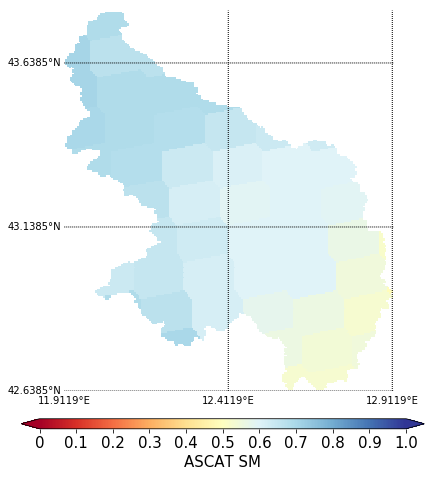

In [52]:
# Plot map of ASCAT SM
data = map_ascat_sm
lons = basin_lons_2d
lats = np.flipud(basin_lats_2d)

vmin = 0
vmax = 1
cb_label='ASCAT SM'

cmap_name='RdYlBu'

minlat = basin_bbox.bottom
maxlat = basin_bbox.top
minlon = basin_bbox.left
maxlon = basin_bbox.right

cb_xticklabels = ['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0']
cb_tickloc = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

norm = mc.Normalize(vmin=vmin, vmax=vmax)

fig, ax = plt.subplots(figsize=(7, 7))
basemap = Basemap(llcrnrlat=minlat, urcrnrlat=maxlat, llcrnrlon=minlon, urcrnrlon=maxlon, resolution='i')
basemap.drawmapboundary(linewidth=0)
#oBaseMap.fillcontinents(color='gray', zorder=2)
basemap.drawparallels(np.arange(minlat, maxlat, 0.5), labels=[True, False, False, False], fontsize=10)
basemap.drawmeridians(np.arange(minlon, maxlon, 0.5), labels=[False, False, False, True], fontsize=10)

basedata = basemap.pcolormesh(lons, lats, 
                                data, shading='flat', norm=norm, cmap=cmap_name)

cb_ax = fig.add_axes([0.1, 0.05, 0.8, 0.02])
cb = fig.colorbar(basedata, orientation='horizontal', cax=cb_ax, extend='both')
cb.set_label(cb_label, fontsize=15)
cb.ax.tick_params(labelsize=15)
cb.set_ticks(cb_tickloc)
cb.ax.set_xticklabels(cb_xticklabels)

filename = os.path.join(exercize_path_img, "lab1_map_ascat_sm.tiff")
fig.savefig(filename, dpi=120)

#### 2. Plot map of ECMWF root zone soil moisture

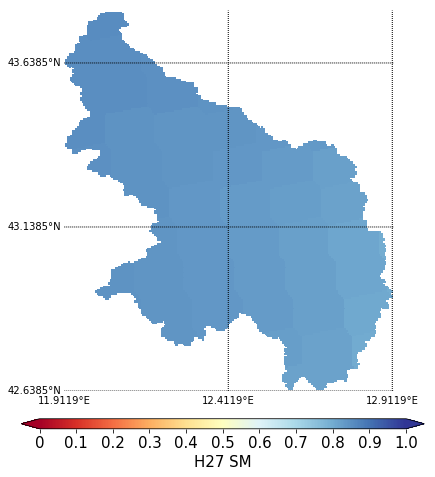

In [53]:
# Plot map of H27 SM
data = map_rzsm_sm
lons = basin_lons_2d
lats = np.flipud(basin_lats_2d)

vmin = 0
vmax = 1
cb_label='H27 SM'

cmap_name='RdYlBu'

minlat = basin_bbox.bottom
maxlat = basin_bbox.top
minlon = basin_bbox.left
maxlon = basin_bbox.right

cb_xticklabels = ['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0']
cb_tickloc = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

norm = mc.Normalize(vmin=vmin, vmax=vmax)

fig, ax = plt.subplots(figsize=(7, 7))
basemap = Basemap(llcrnrlat=minlat, urcrnrlat=maxlat, llcrnrlon=minlon, urcrnrlon=maxlon, resolution='i')
basemap.drawmapboundary(linewidth=0)
#oBaseMap.fillcontinents(color='gray', zorder=2)
basemap.drawparallels(np.arange(minlat, maxlat, 0.5), labels=[True, False, False, False], fontsize=10)
basemap.drawmeridians(np.arange(minlon, maxlon, 0.5), labels=[False, False, False, True], fontsize=10)

basedata = basemap.pcolormesh(lons, lats, 
                                data, shading='flat', norm=norm, cmap=cmap_name)

cb_ax = fig.add_axes([0.1, 0.05, 0.8, 0.02])
cb = fig.colorbar(basedata, orientation='horizontal', cax=cb_ax, extend='both')
cb.set_label(cb_label, fontsize=15)
cb.ax.tick_params(labelsize=15)
cb.set_ticks(cb_tickloc)
cb.ax.set_xticklabels(cb_xticklabels)

filename = os.path.join(exercize_path_img, "lab1_map_rzsm_sm.tiff")
fig.savefig(filename, dpi=120)

#### 3. Plot map of ASCAT soil moisture anomalies

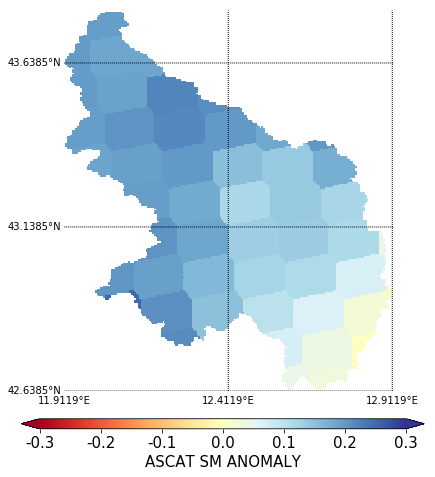

In [54]:
# Plot map of ASCAT SM ANOMALY
data = map_ascat_anml
lons = basin_lons_2d
lats = np.flipud(basin_lats_2d)

vmin = -0.3
vmax = 0.3
cb_label='ASCAT SM ANOMALY'

cmap_name='RdYlBu'

minlat = basin_bbox.bottom
maxlat = basin_bbox.top
minlon = basin_bbox.left
maxlon = basin_bbox.right

cb_xticklabels = ['-0.3', '-0.2', '-0.1', '0.0', '0.1', '0.2', '0.3']
cb_tickloc = [-0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3]

norm = mc.Normalize(vmin=vmin, vmax=vmax)

fig, ax = plt.subplots(figsize=(7, 7))
basemap = Basemap(llcrnrlat=minlat, urcrnrlat=maxlat, llcrnrlon=minlon, urcrnrlon=maxlon, resolution='i')
basemap.drawmapboundary(linewidth=0)
#oBaseMap.fillcontinents(color='gray', zorder=2)
basemap.drawparallels(np.arange(minlat, maxlat, 0.5), labels=[True, False, False, False], fontsize=10)
basemap.drawmeridians(np.arange(minlon, maxlon, 0.5), labels=[False, False, False, True], fontsize=10)

basedata = basemap.pcolormesh(lons, lats, 
                                data, shading='flat', norm=norm, cmap=cmap_name)

cb_ax = fig.add_axes([0.1, 0.05, 0.8, 0.02])
cb = fig.colorbar(basedata, orientation='horizontal', cax=cb_ax, extend='both')
cb.set_label(cb_label, fontsize=15)
cb.ax.tick_params(labelsize=15)
cb.set_ticks(cb_tickloc)
cb.ax.set_xticklabels(cb_xticklabels)

filename = os.path.join(exercize_path_img, "lab1_map_ascat_sm_anomaly.tiff")
fig.savefig(filename, dpi=120)

#### 4. Plot map of ECMWF root zone soil moisture anomalies

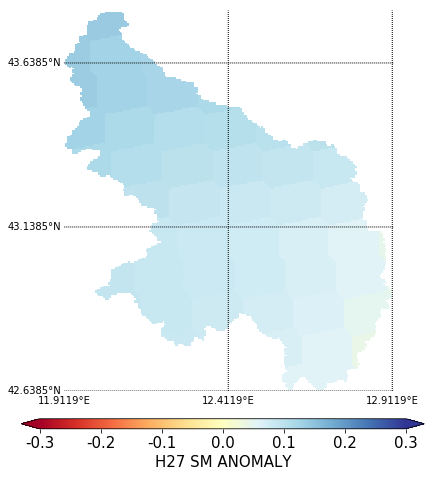

In [55]:
# Plot map of H27 SM ANOMALY
data = map_rzsm_anml
lons = basin_lons_2d
lats = np.flipud(basin_lats_2d)

vmin = -0.3
vmax = 0.3
cb_label='H27 SM ANOMALY'

cmap_name='RdYlBu'

minlat = basin_bbox.bottom
maxlat = basin_bbox.top
minlon = basin_bbox.left
maxlon = basin_bbox.right

cb_xticklabels = ['-0.3', '-0.2', '-0.1', '0.0', '0.1', '0.2', '0.3']
cb_tickloc = [-0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3]

norm = mc.Normalize(vmin=vmin, vmax=vmax)

fig, ax = plt.subplots(figsize=(7, 7))
basemap = Basemap(llcrnrlat=minlat, urcrnrlat=maxlat, llcrnrlon=minlon, urcrnrlon=maxlon, resolution='i')
basemap.drawmapboundary(linewidth=0)
#oBaseMap.fillcontinents(color='gray', zorder=2)
basemap.drawparallels(np.arange(minlat, maxlat, 0.5), labels=[True, False, False, False], fontsize=10)
basemap.drawmeridians(np.arange(minlon, maxlon, 0.5), labels=[False, False, False, True], fontsize=10)

basedata = basemap.pcolormesh(lons, lats, 
                                data, shading='flat', norm=norm, cmap=cmap_name)

cb_ax = fig.add_axes([0.1, 0.05, 0.8, 0.02])
cb = fig.colorbar(basedata, orientation='horizontal', cax=cb_ax, extend='both')
cb.set_label(cb_label, fontsize=15)
cb.ax.tick_params(labelsize=15)
cb.set_ticks(cb_tickloc)
cb.ax.set_xticklabels(cb_xticklabels)

filename = os.path.join(exercize_path_img, "lab1_map_rzsm_sm_anomaly.tiff")
fig.savefig(filename, dpi=120)

### D. Extract ASCAT,  ERA5 and RZSM datasets
#### 1. Extract data of ASCAT and RZSM for a selected date
* define a time analysis (time_analysis)
* define accumulation period for droughts (drough_accum_period in months)
* get drought ssi index value 

In [56]:
# Compute ASCAT SSI drought
drough_accum_period = 1 # 1 month
ts_drought_ssi = pd.DataFrame()
pnt_drought_ssi = pd.DataFrame(columns=['lon', 'lat', 'gpi', 'ssi', 'time'])
for gpi_ascat, lon_ascat, lat_ascat in zip(gpis_basin_ascat, lons_basin_ascat, lats_basin_ascat):
    
    # Info
    ts_sm = 'sm_' + str(gpi_ascat)
    dr_ssi = 'ssi_' + str(gpi_ascat)

    # Compute drought indices
    ts_drought_ssi[dr_ssi] = ssi(ts_ascat_ws, drough_accum_period, ts_sm)

    pnt_ssi = ts_drought_ssi[dr_ssi].loc[time_analysis_last_day]
    
    pnt_drought_ssi = pnt_drought_ssi.append(
        {'lon': lon_ascat, 'lat': lat_ascat, 'gpi': gpi_ascat,
         'ssi': pnt_ssi,
         'time': time_analysis_last_day}, ignore_index=True)

# Print ssi point(s)
print(pnt_drought_ssi.head(n=2)); print(pnt_drought_ssi.tail(n=2))

         lon        lat      gpi       ssi        time
0  11.891937  42.660675  2204747  0.870117  2010-11-30
1  12.044397  42.660675  2204751  0.870117  2010-11-30
          lon        lat      gpi       ssi        time
80  12.733830  43.785828  2251603  0.480964  2010-11-30
81  12.889121  43.785828  2251607  0.480964  2010-11-30


In [57]:
# Compute H27 SSI drought
drough_accum_period = 1 # 1 month
ts_drought_rzsm_ssi = pd.DataFrame()
pnt_drought_rzsm_ssi = pd.DataFrame(columns=['lon', 'lat', 'gpi', 'ssi', 'time'])
for gpi_ascat, lon_ascat, lat_ascat in zip(gpis_basin_ascat, lons_basin_ascat, lats_basin_ascat):
    
    # Info
    ts_sm2 = 'sm_' + str(gpi_ascat)
    dr_rzsm_ssi = 'ssi_' + str(gpi_ascat)

    # Compute drought indices
    ts_drought_rzsm_ssi[dr_rzsm_ssi] = ssi(ts_rzsm_ws, drough_accum_period, ts_sm2)

    pnt_rzsm_ssi = ts_drought_rzsm_ssi[dr_rzsm_ssi].loc[time_analysis_last_day]
    
    pnt_drought_rzsm_ssi = pnt_drought_rzsm_ssi.append(
        {'lon': lon_ascat, 'lat': lat_ascat, 'gpi': gpi_ascat,
         'ssi': pnt_rzsm_ssi,
         'time': time_analysis_last_day}, ignore_index=True)

# Print ssi point(s)
print(pnt_drought_rzsm_ssi.head(n=2)); print(pnt_drought_rzsm_ssi.tail(n=2))

         lon        lat      gpi      ssi        time
0  11.891937  42.660675  2204747  1.48354  2010-11-30
1  12.044397  42.660675  2204751  1.48354  2010-11-30
          lon        lat      gpi      ssi        time
80  12.733830  43.785828  2251603  1.48354  2010-11-30
81  12.889121  43.785828  2251607  1.48354  2010-11-30


#### 2. Interpolation of ASCAT and ECMWF values for selected date (nearest neighbour method)
* all variables (ssi) are interpolated over basin domain
* figures are created and maps are saved as geotiff

In [58]:
# Interpolate ASCAT SSI points over domain
map_drought_ssi = interpolate_point2map(pnt_drought_ssi['lon'].values, pnt_drought_ssi['lat'].values, 
                                        pnt_drought_ssi['ssi'].values, basin_lons_2d, basin_lats_2d)
# Save map in a Tiff format (to plot file using QGIS)
create_map(map_drought_ssi, basin_rows, basin_cols, basin_epsg, basin_transform,
           file_name_data=os.path.join(exercize_path_img, "lab1_map_ssi_drought_qgis.tiff"),
           file_name_mask=os.path.join(domain_path_layer, file_tiff_domain))

# Compute average value
avg_drought_ssi = np.nanmean(map_drought_ssi)
# Print SPI average value(s)
print('SSI index average value: ' + str(avg_drought_ssi))

SSI index average value: 0.9160333626612646


In [59]:
# Interpolate H27 SSI points over domain
map_drought_rzsm_ssi = interpolate_point2map(pnt_drought_rzsm_ssi['lon'].values, pnt_drought_rzsm_ssi['lat'].values, 
                                        pnt_drought_rzsm_ssi['ssi'].values, basin_lons_2d, basin_lats_2d)
# Save map in a Tiff format (to plot file using QGIS)
create_map(map_drought_rzsm_ssi, basin_rows, basin_cols, basin_epsg, basin_transform,
           file_name_data=os.path.join(exercize_path_img, "lab1_map_rzsm_ssi_drought_qgis.tiff"),
           file_name_mask=os.path.join(domain_path_layer, file_tiff_domain))

# Compute average value
avg_drought_rzsm_ssi = np.nanmean(map_drought_rzsm_ssi)
# Print SPI average value(s)
print('H27 SSI index average value: ' + str(avg_drought_rzsm_ssi))

H27 SSI index average value: 1.4835398594012976


### Plot maps

#### 1. Plot map of ASCAT SSI

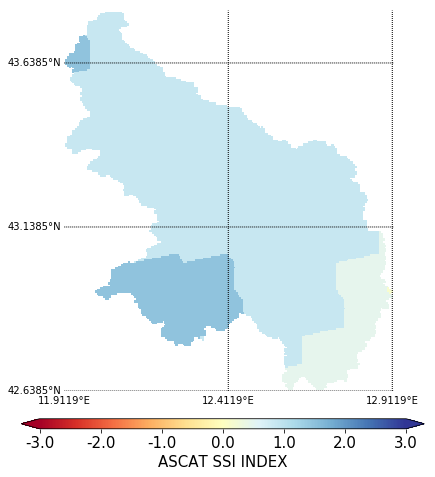

In [60]:
# Plot map of ASCAT SSI 
data = map_drought_ssi
lons = basin_lons_2d
lats = np.flipud(basin_lats_2d)

vmin = -3
vmax = 3
cb_label='ASCAT SSI INDEX'

cmap_name='RdYlBu'

minlat = basin_bbox.bottom
maxlat = basin_bbox.top
minlon = basin_bbox.left
maxlon = basin_bbox.right

cb_xticklabels = ['-3.0', '-2.0', '-1.0', '0.0', '1.0', '2.0', '3.0']
cb_tickloc = [-3.0, -2.0, -1.0, 0, 1.0, 2.0, 3.0]

norm = mc.Normalize(vmin=vmin, vmax=vmax)

fig, ax = plt.subplots(figsize=(7, 7))
basemap = Basemap(llcrnrlat=minlat, urcrnrlat=maxlat, llcrnrlon=minlon, urcrnrlon=maxlon, resolution='i')
basemap.drawmapboundary(linewidth=0)
#oBaseMap.fillcontinents(color='gray', zorder=2)
basemap.drawparallels(np.arange(minlat, maxlat, 0.5), labels=[True, False, False, False], fontsize=10)
basemap.drawmeridians(np.arange(minlon, maxlon, 0.5), labels=[False, False, False, True], fontsize=10)

basedata = basemap.pcolormesh(lons, lats, 
                                data, shading='flat', norm=norm, cmap=cmap_name)

cb_ax = fig.add_axes([0.1, 0.05, 0.8, 0.02])
cb = fig.colorbar(basedata, orientation='horizontal', cax=cb_ax, extend='both')
cb.set_label(cb_label, fontsize=15)
cb.ax.tick_params(labelsize=15)
cb.set_ticks(cb_tickloc)
cb.ax.set_xticklabels(cb_xticklabels)

filename = os.path.join(exercize_path_img, "lab1_map_ssi_drought.tiff")
fig.savefig(filename, dpi=120)

#### 2. Plot map of ECMWF SSI

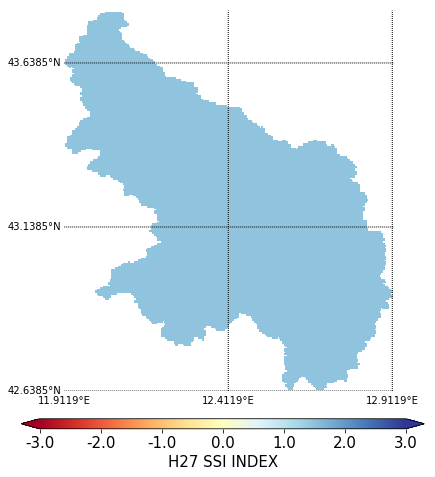

In [61]:
# Plot map of H27 SSI 
data = map_drought_rzsm_ssi
lons = basin_lons_2d
lats = np.flipud(basin_lats_2d)

vmin = -3
vmax = 3
cb_label='H27 SSI INDEX'

cmap_name='RdYlBu'

minlat = basin_bbox.bottom
maxlat = basin_bbox.top
minlon = basin_bbox.left
maxlon = basin_bbox.right

cb_xticklabels = ['-3.0', '-2.0', '-1.0', '0.0', '1.0', '2.0', '3.0']
cb_tickloc = [-3.0, -2.0, -1.0, 0, 1.0, 2.0, 3.0]

norm = mc.Normalize(vmin=vmin, vmax=vmax)

fig, ax = plt.subplots(figsize=(7, 7))
basemap = Basemap(llcrnrlat=minlat, urcrnrlat=maxlat, llcrnrlon=minlon, urcrnrlon=maxlon, resolution='i')
basemap.drawmapboundary(linewidth=0)
#oBaseMap.fillcontinents(color='gray', zorder=2)
basemap.drawparallels(np.arange(minlat, maxlat, 0.5), labels=[True, False, False, False], fontsize=10)
basemap.drawmeridians(np.arange(minlon, maxlon, 0.5), labels=[False, False, False, True], fontsize=10)

basedata = basemap.pcolormesh(lons, lats, 
                                data, shading='flat', norm=norm, cmap=cmap_name)

cb_ax = fig.add_axes([0.1, 0.05, 0.8, 0.02])
cb = fig.colorbar(basedata, orientation='horizontal', cax=cb_ax, extend='both')
cb.set_label(cb_label, fontsize=15)
cb.ax.tick_params(labelsize=15)
cb.set_ticks(cb_tickloc)
cb.ax.set_xticklabels(cb_xticklabels)

filename = os.path.join(exercize_path_img, "lab1_map_rzsm_ssi_drought.tiff")
fig.savefig(filename, dpi=120)

### E. Extract ASCAT,  ERA5 and RZSM datasets
#### 1. Extract data of ERA5 for a selected date
* define a time analysis (time_analysis)
* define accumulation period for droughts (drough_accum_period in months)
* get drought spi index value 

In [62]:
# Compute drought SPI
drough_accum_period = 1 # 1 month
ts_drought_spi = pd.DataFrame()
pnt_drought_spi = pd.DataFrame(columns=['lon', 'lat', 'gpi', 'spi', 'time'])
for gpi_ascat, lon_ascat, lat_ascat in zip(gpis_basin_ascat, lons_basin_ascat, lats_basin_ascat):
    
    # Info
    ts_tp = 'tp_' + str(gpi_ascat)
    dr_spi = 'spi_' + str(gpi_ascat)
        
    # Compute drought indices
    ts_drought_spi[dr_spi] = spi(ts_era5_ws, drough_accum_period, ts_tp)
    
    pnt_spi = ts_drought_spi[dr_spi].loc[time_analysis_last_day]
    
    pnt_drought_spi = pnt_drought_spi.append(
        {'lon': lon_ascat, 'lat': lat_ascat, 'gpi': gpi_ascat,
         'spi': pnt_spi,
         'time': time_analysis_last_day}, ignore_index=True)

# Print spi point(s)
print(pnt_drought_spi.head(n=2)); print(pnt_drought_spi.tail(n=2))

         lon        lat      gpi      spi        time
0  11.891937  42.660675  2204747  1.48354  2010-11-30
1  12.044397  42.660675  2204751  1.48354  2010-11-30
          lon        lat      gpi       spi        time
80  12.733830  43.785828  2251603  0.870117  2010-11-30
81  12.889121  43.785828  2251607  0.870117  2010-11-30


#### 2. Interpolation of ERA5 values for selected date (nearest neighbour method)
* all variables (spi) are interpolated over basin domain
* figures are created and maps are saved as geotiff

In [63]:
# Interpolate SPI values over domain
map_drought_spi = interpolate_point2map(pnt_drought_spi['lon'].values, pnt_drought_spi['lat'].values, 
                                        pnt_drought_spi['spi'].values, basin_lons_2d, basin_lats_2d)
# Save map in a Tiff format (to plot file using QGIS)
create_map(map_drought_spi, basin_rows, basin_cols, basin_epsg, basin_transform,
           file_name_data=os.path.join(exercize_path_img, "lab1_map_spi_drought_qgis.tiff"),
           file_name_mask=os.path.join(domain_path_layer, file_tiff_domain))

# Compute average value
avg_drought_spi = np.nanmean(map_drought_spi)
# Print SPI average value(s)
print('SPI index average value: ' + str(avg_drought_spi))

SPI index average value: 1.2188558801836145


### Plot maps

### Plot map of ERA5 spi

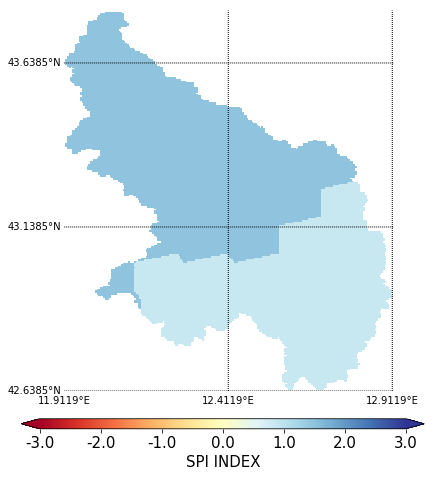

In [64]:
# Plot map of SPI 
data = map_drought_spi
lons = basin_lons_2d
lats = np.flipud(basin_lats_2d)

vmin = -3
vmax = 3
cb_label='SPI INDEX'

cmap_name='RdYlBu'

minlat = basin_bbox.bottom
maxlat = basin_bbox.top
minlon = basin_bbox.left
maxlon = basin_bbox.right

cb_xticklabels = ['-3.0', '-2.0', '-1.0', '0.0', '1.0', '2.0', '3.0']
cb_tickloc = [-3.0, -2.0, -1.0, 0, 1.0, 2.0, 3.0]

norm = mc.Normalize(vmin=vmin, vmax=vmax)

fig, ax = plt.subplots(figsize=(7, 7))
basemap = Basemap(llcrnrlat=minlat, urcrnrlat=maxlat, llcrnrlon=minlon, urcrnrlon=maxlon, resolution='i')
basemap.drawmapboundary(linewidth=0)
#oBaseMap.fillcontinents(color='gray', zorder=2)
basemap.drawparallels(np.arange(minlat, maxlat, 0.5), labels=[True, False, False, False], fontsize=10)
basemap.drawmeridians(np.arange(minlon, maxlon, 0.5), labels=[False, False, False, True], fontsize=10)

basedata = basemap.pcolormesh(lons, lats, 
                                data, shading='flat', norm=norm, cmap=cmap_name)

cb_ax = fig.add_axes([0.1, 0.05, 0.8, 0.02])
cb = fig.colorbar(basedata, orientation='horizontal', cax=cb_ax, extend='both')
cb.set_label(cb_label, fontsize=15)
cb.ax.tick_params(labelsize=15)
cb.set_ticks(cb_tickloc)
cb.ax.set_xticklabels(cb_xticklabels)

filename = os.path.join(exercize_path_img, "lab1_map_spi_drought.tiff")
fig.savefig(filename, dpi=120)